In [1]:
import pandas as pd
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import WeightedRandomSampler
import pydicom
from pynetdicom import AE, evt
from pynetdicom.sop_class import CTImageStorage, PatientRootQueryRetrieveInformationModelGet

In [2]:
data = pd.read_csv("metadata.csv")
data

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.493562949900...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.116951808801...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,DX,Digital X-Ray Image Storage - For Presentation,1.2.840.10008.5.1.4.1.1.1.1,1,6.91 MB,.\LIDC-IDRI\LIDC-IDRI-0002\01-01-2000-NA-NA-26...,2023-11-02T21:36:33.93
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.141365756818...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.175012972118...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,DX,Digital X-Ray Image Storage - For Presentation,1.2.840.10008.5.1.4.1.1.1.1,2,16.36 MB,.\LIDC-IDRI\LIDC-IDRI-0001\01-01-2000-NA-NA-35...,2023-11-02T21:37:48.38
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,133,70.33 MB,.\LIDC-IDRI\LIDC-IDRI-0001\01-01-2000-NA-NA-30...,2023-11-02T21:45:25.628
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,140,74.11 MB,.\LIDC-IDRI\LIDC-IDRI-0003\01-01-2000-NA-NA-94...,2023-11-02T21:47:20.507
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.142026812390...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.202063331127...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,DX,Digital X-Ray Image Storage - For Presentation,1.2.840.10008.5.1.4.1.1.1.1,5,38.59 MB,.\LIDC-IDRI\LIDC-IDRI-0003\01-01-2000-NA-NA-59...,2023-11-02T21:49:35.748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1.3.6.1.4.1.14519.5.2.1.6279.6001.406508755509...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0315,1.3.6.1.4.1.14519.5.2.1.6279.6001.190722769298...,NaN,01-01-2000,ThorRoutine 3.0 B31f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,122,64.34 MB,.\LIDC-IDRI\LIDC-IDRI-0315\01-01-2000-NA-NA-72...,2024-01-05T11:26:23.258
603,1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0317,1.3.6.1.4.1.14519.5.2.1.6279.6001.639539378810...,CT LUNG SCREEN,01-01-2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,124,65.28 MB,.\LIDC-IDRI\LIDC-IDRI-0317\01-01-2000-NA-CT LU...,2024-01-05T11:27:50.952
604,1.3.6.1.4.1.14519.5.2.1.6279.6001.160216916075...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0316,1.3.6.1.4.1.14519.5.2.1.6279.6001.219338237072...,NaN,01-01-2000,NaN,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,201,105.80 MB,.\LIDC-IDRI\LIDC-IDRI-0316\01-01-2000-NA-NA-62...,2024-01-05T11:27:54.222
605,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0319,1.3.6.1.4.1.14519.5.2.1.6279.6001.684596493379...,NaN,01-01-2000,NaN,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,195,102.68 MB,.\LIDC-IDRI\LIDC-IDRI-0319\01-01-2000-NA-NA-73...,2024-01-05T11:29:57.182


In [3]:
file_path = "1-002.dcm"
data = pydicom.dcmread(file_path)
print(data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.512235483218154065970649917292
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.51223

[[-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 ...
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]]


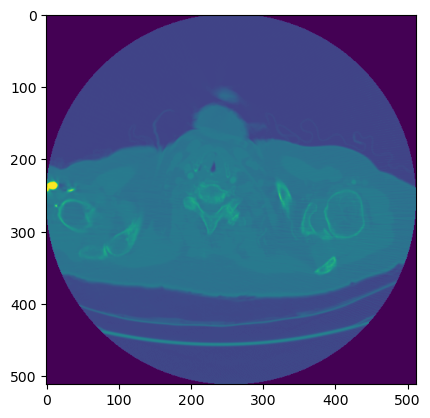

In [4]:
file_path = "1-002.dcm"  # Replace 'username' and 'your_dcm_file.dcm' with your actual username and dcm file name
ds = pydicom.dcmread(file_path)

# Rescale the image data
rescale_intercept = ds.RescaleIntercept
rescale_slope = ds.RescaleSlope
pixel_array = ds.pixel_array * rescale_slope + rescale_intercept

# Convert the image data to a NumPy array
image = np.array(pixel_array, dtype=float)

print(image)
plt.imshow(image)

